# Projeto Pipeline de dados para Ingestão, ETL e apresentação de Dados do Telegram na AWS.

Luís Felipe Barreto

## 1. Introdução

O presente projeto foi desenvolvido como última etapa para a conclusão do curso de Analista de Dados da EBAC (Escola Britânica de Artes Criativas & Tecnologia).
O pipeline de dados tem como objetivo ingerir, processar e armazenar dados provenientes de um grupo criado exclusivamente para esse projeto, no aplicativo de mensagens telegram.

O trabalho proposto é realizar uma análise exploratória dos dados enviados ao chatbot (nesse caso são mensagens de texto) para esclarecer algumas questões que possam basear tomadas de decisão a depender do contexto em que o bot está aplicado. Por exemplo, como o público interage com o bot, seja com relação a horários, qual o teor predominante das mensagens, quem são os que mais interagem com o bot, etc.
Para isso, construímos um pipeline de dados, onde vamos ingerir, processar, armazenar as mensagens que estão sendo enviadas ao chatbot via telegram e então apresentá-los no ambiente da AWS por consultas SQL. A imagem abaixo demonstra o fluxo do presente projeto:

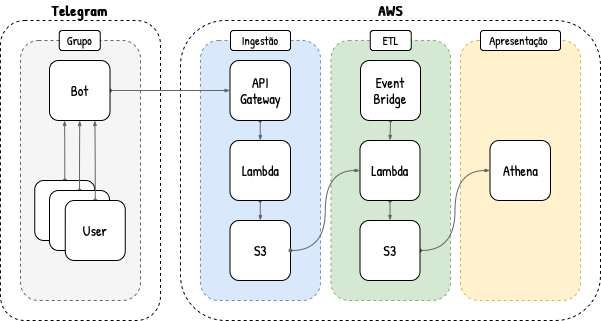

Primeiramente, iremos entender o que é a AWS, Telegram e chatbot.
A AWS (Amazon Web Services) é uma plataforma de computação em nuvem, oferecendo mais de 200 serviços de infraestrutura de TI, como computação, armazenamento e bancos de dados, através de datacenters espalhados globalmente. Os clientes, que incluem desde startups a grandes empresas e agências governamentais, podem utilizar esses serviços de forma sob demanda, pagando apenas pelo que usam, o que permite reduzir custos e aumentar a agilidade.

O Telegram é um aplicativo de mensagens instantâneas gratuito, baseado na nuvem e com foco em velocidade e segurança. Ele permite a comunicação por chats individuais e em grupo, chamadas de voz e vídeo, além de recursos como canais, bots e o envio de arquivos grandes. A sincronização em múltiplos dispositivos é uma de suas principais características, permitindo que você acesse suas mensagens em qualquer um dos seus aparelhos.

Um chatbot é um programa de computador que simula uma conversa humana por meio de texto ou voz, projetado para interagir com usuários para responder perguntas, executar tarefas ou fornecer informações. Eles podem ser baseados em regras pré-programadas ou usar inteligência artificial (IA) para gerar respostas mais complexas e naturais. Podem ter várias aplicações, como no atendimento ao cliente, assistência virtual, vendas e telemarketing, comunicação interna etc.

Visto a difusão crescente desse tipo de ferramenta no mercado, na área de dados é importante que tenhamos o know-how de como extrair informações relevantes para tomadas de decisões mais assertivas.

Para começarmos, abri um chat com o BotFather (uma espécie de administrador de bots do seu telegram) para criar um bot para o objetivo do trabalho e então adicioná-lo à um grupo no telegram para controlar as mensagens. A documentação da API (*application programming interface*) de *bots* dos **Telegram** está presente neste [link](https://core.telegram.org/bots/api)).
Nesse caso, criei um bot chamado "*proj_datapipeline_bot*" e o adicionei a um grupo recém-criado chamado "*Project Data Pipeline Bot*", no qual, além de mim, adicionei mais duas pessoas de minha confiança para ter uma maior amostragem de mensagens de usuários.

Nesse projeto, as mensagens recebidas pelo bot podem ser ingeridas através da API web de bots do Telegram, portanto são fornecidos no formato JSON. Porém, o telegram só retém as mensagens por 24h. Preciso que os dados sejam ingeridos conforme são produzidos e então disponibilizados, a chamada ingestão via streaming. Para que isso seja possível, utilizaremos um webhook, redirecionando as mensagens automaticamente para outra API web, o AWS API Gateway (documentação neste [link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html)). A API criada no Gateway ser conectada ao AWS Lambda, que irá armazenar os dados recebidos em formato original JSON um bucket no AWS S3.

As mensagens enviadas no grupo do telegram são recebidas pelo bot e podem ser acessadas via API. Para isso é preciso inserir o token do bot, que podemos obter facilmente pelo BotFather, e iremos armazená-lo em uma variável, como mostrado abaixo:

In [ ]:
from getpass import getpass

token = getpass()

# a base URL é comum a todos os métodos da API

import json

base_url = f'https://api.telegram.org/bot{token}'

Vamos utilizar o método getMe para verificar as informações sobre o bot.

In [ ]:
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

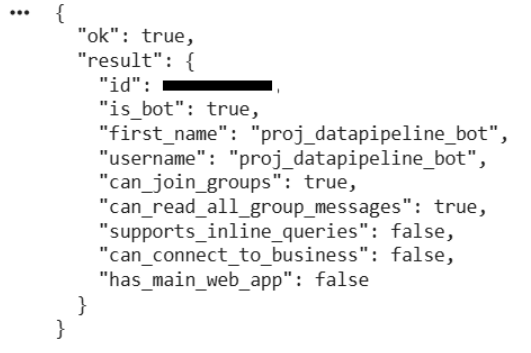![image.png](attachment:37e5a618-f62f-4acf-8b26-7fc7dc039464.png)

E para verificar as mensagens captadas pelo bot, usaremos o método getUpdates

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

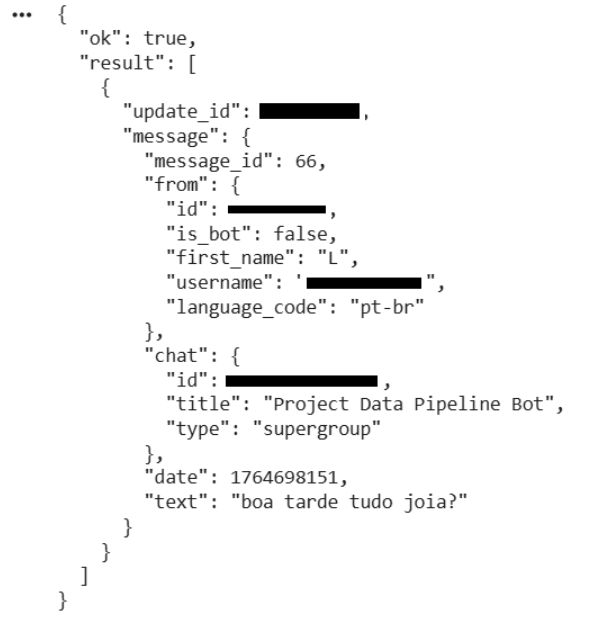![image.png](attachment:47cf2e37-0371-4e55-a6f5-482ce26873e0.png)

## 2. Ingestão

Nessa etapa, iremos utilizar o AWS Lambda para persistir as mensagens captadas pelo bot do Telegram em um bucket do AWS S3. A função Lambda será ativada a partir do AWS API Gateway, como anteriormente mencionado, que irá receber as mensagens caputuradas pelo bot do telegram via webhook.

Primeiramente, criei um bucket no AWS S3 chamado "modulo-42-luisfelipe-datalake-raw" para receber esses dados crus em formato JSON. Com o bucket criado partimos para o AWS Lambda, onde a função criada deverá operar da seguinte forma:
- Recebe a mensagem no parâmetro event;
- Verifica se a mensagem tem origem no grupo do Telegram correto;
- Persiste a mensagem no formato JSON no bucket do AWS S3;
- Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de bots do Telegram.

Note que antes de fazer o deploy e teste da função devemos configurar as variáveis de ambiente para proteger os dados sensíveis, que no caso são o caminho para o nosso bucket no S3 e o ID do chat do Telegram. Além disso devemos configurar as devidas permissões do AWS Lambda sobre o AWS S3, utilizando o AWS IAM

In [ ]:
!pip install boto3

import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Com a função criada, criamos um método HTTP para essa API do tipo POST no AWS API Gateway para interagir com o Lambda. Feito isso, iremos configurar o webhook para direcionar as mensagens para a url do AWS API Gateway.

In [ ]:
aws_api_gateway_url = getpass()

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

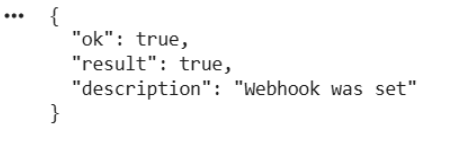![image.png](attachment:8f7d81de-fb54-400d-8761-f4239f2c342e.png)

Vamos utilizar o método *getWebhookInfo* para verificar se o webhook foi configurado corretamente.

response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

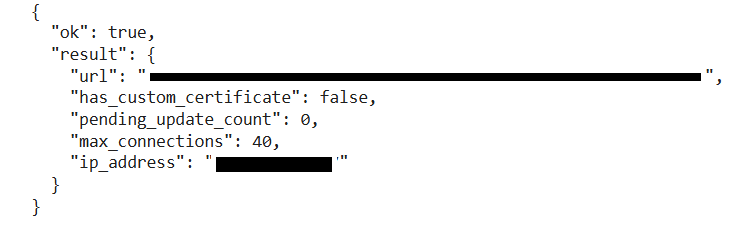![image.png](attachment:257cd926-728e-4282-aba5-0de14755148a.png)

## 3. ETL (Extraction, Transformation and Load)

Nessa etapa, será realizado a manipulação dos dados crus persistidos. Tais dados passarão por um processo onde ele é limpo, compactado em um único formato do tipo parquet particionado e armazenado em um outro bucket, chamado bucket enriched.

Para que diariamente as mensagens sejam processadas automaticamente (trabalharemos processando as mensagens sempre do dia anterior, D-1), iremos utilizar o AWS Event Bridge, configurando-o para que em um determinado horário acione uma outra função no AWS Lambda, que então processará as mensagens,, processando o dado original do formato JSON, compacta no formato Apache Parquet e armazenando no AWS S3 particionado por dia.

O primeiro passo dessa etapa então é criar um bucket no S3 para a camada enriquecida dos nossos dados, nesse caso o denominei de "modulo-42-luisfelipe-datalake-enriched". Com o bucket criado, podemos criar a função Lambda que será acionada pelo Event Bridge que terá a função de:
- Lista todos os arquivos JSON de uma única participação da camada crua de um bucket do AWS S3;
- Para cada arquivo listado:
- Faz o download do arquivo e carrega o conteúdo da mensagem;
- Executa uma função de data wrangling;
- Cria uma tabela do PyArrow e a contatena com as demais.
- Persiste a tabela no formato Parquet na camada enriquecida em um bucket do AWS S3.

Note que para que haja o bom funcionamento da função devemos novamente configurar as devidas variáveis de ambiente AWS_S3_BUCKET e AWS_S3_ENRICHED, dar as devidas permissões para a função no AWS IAM, além de criar uma camada na função para adicionar o pacote PyArrow. Para inserir o pacote PyArrow via camada no AWS Lambda devemos criar um bucket no AWS S3, fazer o upload do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases)) e então criar a camada conectando na função. Segue o código da função no AWS Lambda abaixo:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

# Código da função de data wrangling:

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Com a função criada, vamos fazer com que essa função rode automaticamente em um horário determinado diariamente, faremos isso utilizando o AWS Event Bridge. Nesse caso, optei por criar a regra para rodar todo dia à meia-noite.

## 4. Análise Exploratória de Dados

Com os dados devidamente limpos, particionados e armazenados, podemos começar nossa etapa de análise exploratória de dados. Para isso, iremos usar o AWS Athena para realizar algumas consultas SQL e então verificar o que os dados podem nos dizer.

Nesta etapa, a função do AWS Athena é apresentar aos usuários os dados, através de consultas SQL. Para isso, devemos criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida. O código abaixo irá criar essa tabela externa. Note que devemos alterar o caminho do nosso bucket enriquecido.

In [ ]:
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'

Com a tabela criada, devemos carregar as partições.

In [ ]:
MSCK REPAIR TABLE `telegram`;

Agora com as partições criadas, vamos observar as 10 primeiras mensagens captadas pelo bot. Rodei a seguinte consulta SQL no Athena:

In [ ]:
SELECT * FROM "telegram" ORDER BY context_date LIMIT 10;

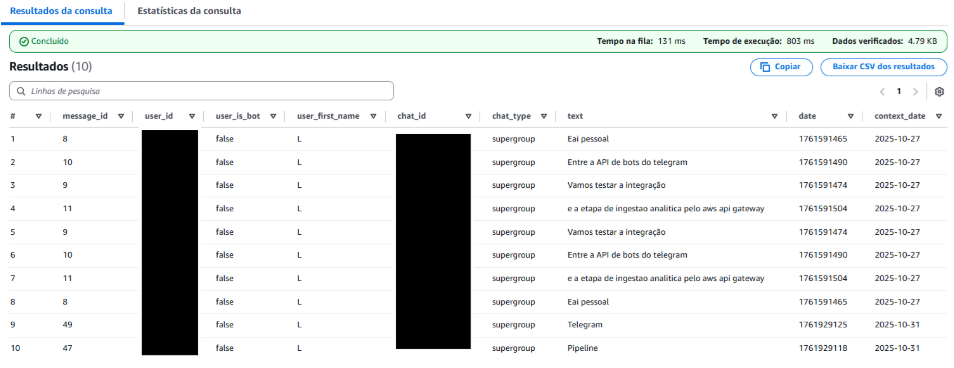

Podemos começar nossas consultas tentando entender alguns pontos básicos como:

- Quantidade de mensagens enviadas por dia;
- Quantidade de mensagens por usuário por dia;
- Média do tamanho das mensagens por usuário por dia;
- Quantidade de mensagens por hora por dia da semana por número da semana;

In [ ]:
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC

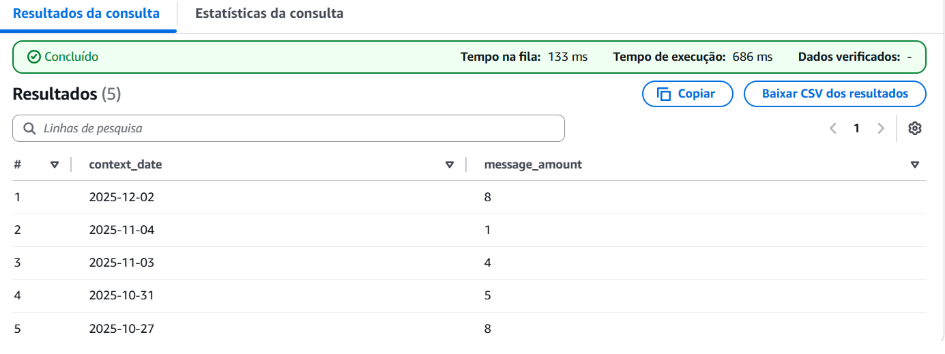

Podemos observar que nas datas disponíveis para consulta, tivemos um máximo de 8 mensagens enviadas no dia em duas ocasiões e houve um dia em que apenas uma mensagem foi enviada, sendo o mínimo registrado.

In [ ]:
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

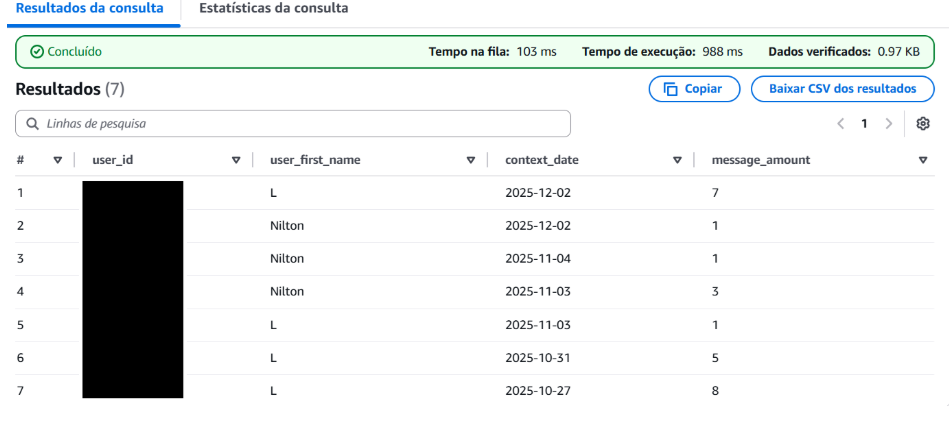

Acima podemos ver que apenas dois usuários interagiram no chat nos dias disponíveis, e apenas em duas ocasiões eles interagiram no mesmo dia.

In [ ]:
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

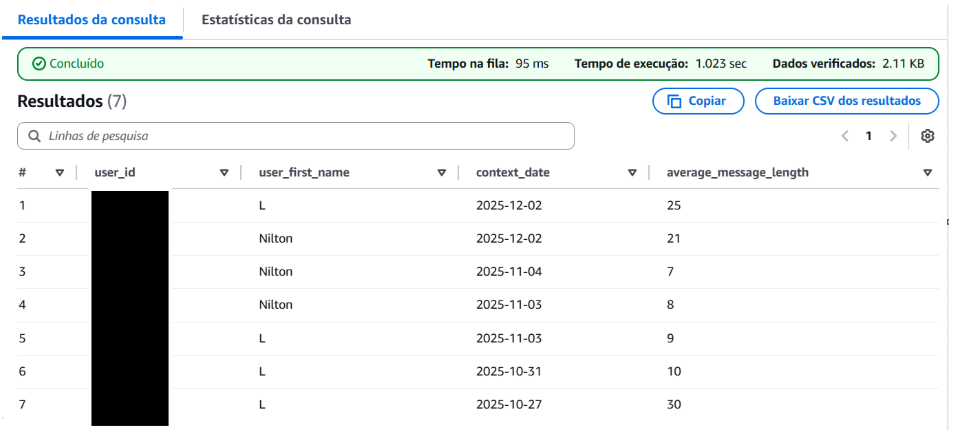

In [ ]:
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

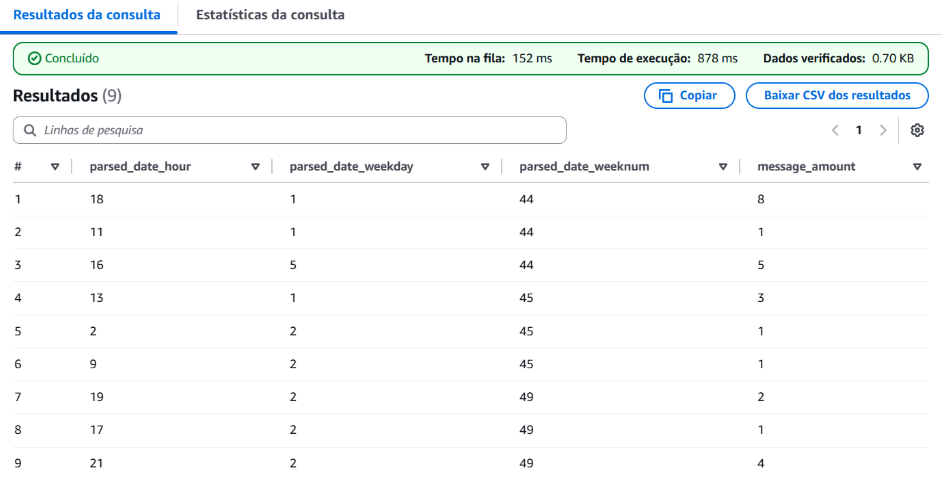

A coluna "parsed_date_hour" representa a hora do dia, "parsed_date_weekday" representa o dia da semana, sendo 0 o domingo, 1 segunda-feira e assim por diante até 6 que seria o sábado. A coluna "parsed_date_weeknum" representa a semana do ano, considerando que o ano de 2025 teve 52 semanas. Por fim, a coluna "message_amount" indica a quantidade de mensagens enviadas naquela hora, naquele dia da semana, naquela semana específica do ano.

Pensando que podemos ter vários usuários interagindo com nosso bot, seria uma boa oportunidade identificar quais usuários são os que mais interagem.

In [ ]:
SELECT
    user_id,
    user_first_name,
    COUNT(message_id) AS total_mensagens
FROM
    "telegram"
GROUP BY
    user_id, user_first_name
ORDER BY
    total_mensagens DESC
LIMIT 5;

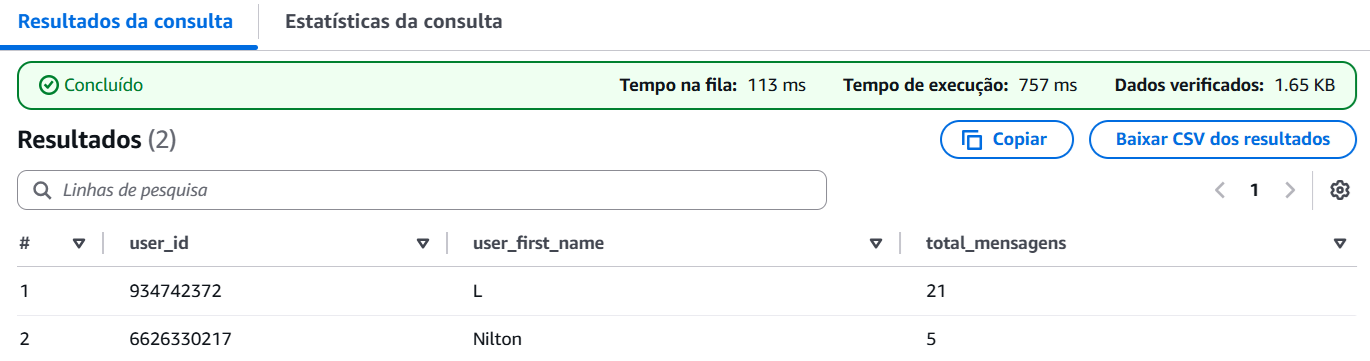

Também podemos fazer uma análise de picos de atividade, as tendências horárias de uso do chatbot. Embora já tenhamos a quantidade de mensagens por hora, poderíamos analisar a média de mensagens por hora, agregada por hora do dia. Isso pode revelar tendências de uso do usuário, por exemplo, a hora mais comum para usar o chatbot, independentemente do dia.

In [ ]:
WITH parsed_date_cte AS (
    SELECT
        *,
        CAST(from_unixtime("date") AS timestamp) AS parsed_date
    FROM "telegram"
)
SELECT
    EXTRACT(HOUR FROM parsed_date) AS hora_do_dia,
    COUNT(message_id) AS total_mensagens_na_hora
FROM
    parsed_date_cte
GROUP BY EXTRACT(HOUR FROM parsed_date)
ORDER BY total_mensagens_na_hora DESC;

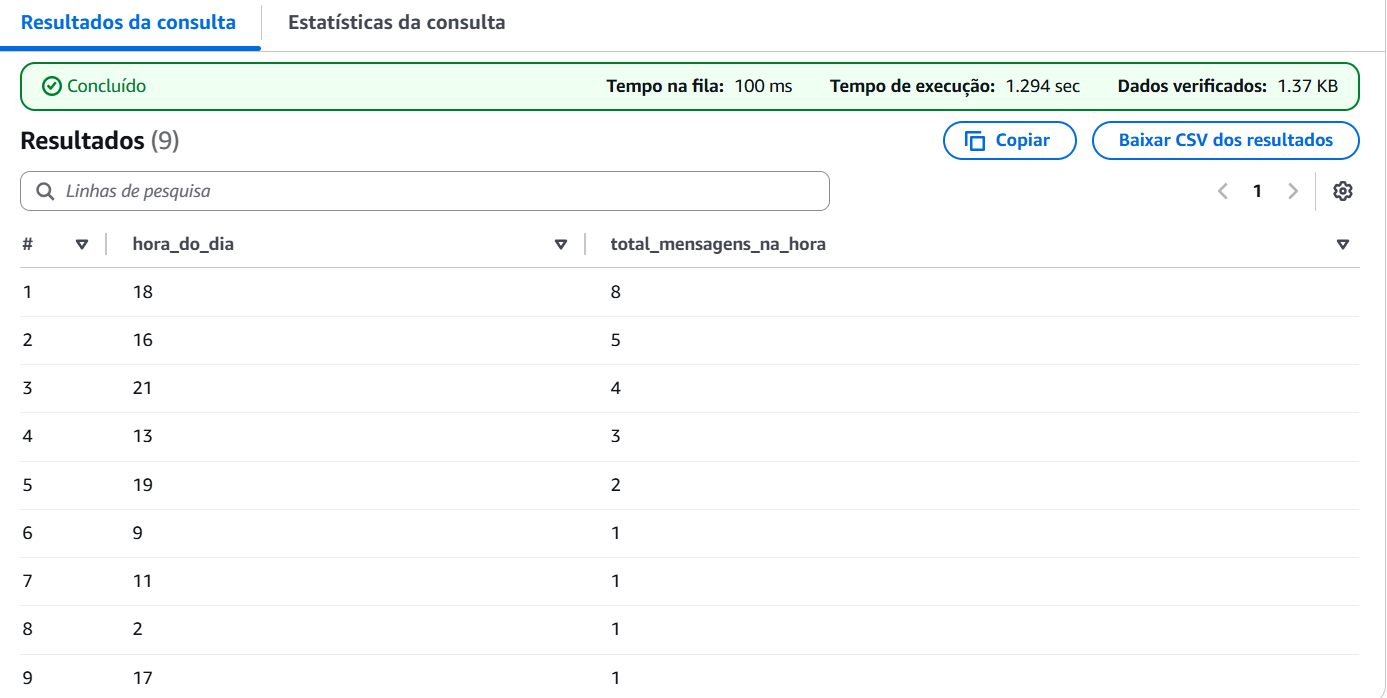

Essa consulta nos permitiu verificar que a maioria das mensagens são enviadas no final da tarde ou no período da noite, e que poucas mensagens são enviadas no período da manhã.

## 5. Conclusão

Nesse projeto pude compreender um pouco mais sobre o poder da análise de dados escalando a ideia do projeto para um ambiente de grande empresa por exemplo. O uso dos chatbots por sua vez demonstrou o porquê de serem cada vez mais utilizados por grandes empresas, visto que automatizam funções reduzindo custos, podendo resolver tarefas por nós humanos, além de fornecer dados para que os gestores possam tomar decisões assertivas sobre o produto em questão, analisando o perfil e comportamento dos seus clientes, teores das interações, feedbacks etc.

Também pude perceber as vantagens dos serviços em nuvem quando se trata de big data, onde as cobranças financeiras são baixas relativos ao volume de dados tratados, especialmente se a equipe de dados tiver a sensibilidade de otimizar as consultas para gerar menores varreduras e assertividade nas consultas.

Os dados tratados ainda podem ter melhorias, como conexão com uma ferramenta de visualização de dados, como o Looker Studio ou o Power BI, ou mesmo baixar os resultados em csv e migrá-los para o python onde com pacotes como o Seaborn poderíamos criar imagens para ilustrar os dados colhidos.